In [ ]:
# imports

# pretend we are in the root folder:
import sys
sys.path.append("../")

from udl_2024_package.datasets import remove_dataset_labels, default_img_transforms
from udl_2024_package.nn import unet_factory, discriminator_factory
from udl_2024_package.vincent_diffusion import DiffusionModel

import torch
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10, MNIST

import lightning as L

/home/vincent/miniforge3/envs/pytorch_base/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Creating the datasets:
# TODO: test if this also works with MNIST
# trainset, testset = dataset_factory(MNIST)
dataset_path = "./datasets"
trainset = remove_dataset_labels(MNIST(dataset_path, transform=default_img_transforms(1), train=True, download=True))
testset = remove_dataset_labels(MNIST(dataset_path, transform=default_img_transforms(1), train=False, download=True))

batch_size = 32
dl_kwargs = {
    "batch_size": batch_size, "shuffle": True, "num_workers": 4, "pin_memory": True,
}

trainloader = DataLoader(
    trainset, **dl_kwargs
)
testloader = DataLoader(
    testset, **dl_kwargs
)

batch = next(iter(trainloader))

In [ ]:
unet = unet_factory(28, 1)
print(f"{sum(p.numel() for p in unet.parameters() if p.requires_grad):_}")

35_746_307


In [15]:
noise = torch.randn_like(batch)
ts = torch.full((len(batch),), 999, device=batch.device)
unet(noise, ts).shape

torch.Size([32, 3, 32, 32])

In [5]:
discriminator = discriminator_factory(3)
print(f"{sum(p.numel() for p in discriminator.parameters() if p.requires_grad):_}")

21_285_185


In [ ]:
from torch import nn
from udl_2024_package.vincent_wgan import WGANWithGradientPenaltyFuncs

class WGANWithGradientPenalty(L.LightningModule):
    """Wasserstein Gan that uses Gradient Penalty instead of weight clipping."""

    def __init__(
            self,
            generator: nn.Module,
            critic: nn.Module,
            generator_func,
            gp_weight: float = 10,
            critic_iterations: int = 5,
            optimizer_cls: type[torch.optim.Optimizer] = torch.optim.Adam,
            optimizer_args: dict = {"lr": 1e-4, "betas": (0.5, 0.99)}
    ):
        """
        Args:
            generator: the generator model for the WGAN
            critic: the critic model for the WGAN. Outputs single scalar value
            generator_func: function `generator_func(generator, batch)` that
                takes the generator and a batch (to get right shape) as input
                and outputs generated images.
            gp_weight: gradient penalty weight. See `WGANWithGradientPenaltyFuncs`
            critic_iterations: See `WGANWithGradientPenaltyFuncs`
            optimizer_cls: e.g. Adam
            optimizer_args: dict of args to give to optimizer (excluding
                model params, of course)
        """
        super().__init__()
        self.gen = generator
        self.cri = critic
        self.gen_func = generator_func
        self.wgan_funcs = WGANWithGradientPenaltyFuncs(gp_weight, critic_iterations)
        self.optimizer_cls = optimizer_cls
        self.optimizer_args = optimizer_args

        self.automatic_optimization = False
    
    def forward(self, x):
        return self.gen(x)

    def training_step(self, batch, batch_idx):
        opt_g, opt_c = self.optimizers()

        self.toggle_optimizer(opt_c)

        # Creating fake images
        with torch.no_grad():
            # noise = torch.randn((batch.shape[0], 100, 1, 1), device=self.device)
            fake_imgs = self.gen_func(self.gen, batch)
        
        loss_critic = self.wgan_funcs.critic_loss(self.cri, batch, fake_imgs)

        # Weight update:
        opt_c.zero_grad()
        self.manual_backward(loss_critic)
        opt_c.step()
        self.log("train/loss_critic", loss_critic, prog_bar=True)

        self.untoggle_optimizer(opt_c) # not really sure if needed but well..
        
        also_train_generator = self.wgan_funcs.also_train_generator(batch_idx)

        if also_train_generator:
            self.toggle_optimizer(opt_g)

            # Generate images:
            fake_imgs = self.gen_func(self.gen, batch)
            loss_gen = self.wgan_funcs.generator_loss(self.cri, fake_imgs)

            # Weight update:
            opt_g.zero_grad()
            self.manual_backward(loss_gen)
            opt_g.step()
            
            self.log("train/loss_generator", loss_gen, prog_bar=True)

            self.untoggle_optimizer(opt_g)
    
    def configure_optimizers(self):
        opt_g = self.optimizer_cls(self.gen.parameters(), **self.optimizer_args)
        opt_c = self.optimizer_cls(self.cri.parameters(), **self.optimizer_args)
        return opt_g, opt_c

img_size = (32,32,3)

def generate_samples(generator, real_batch):
    noise = torch.randn_like(real_batch)
    ts = torch.full((len(real_batch),), 999, device=real_batch.device)
    return generator(noise, ts)

wgan = WGANWithGradientPenalty(
    unet,
    discriminator,
    generate_samples
)

# Experiment
trainer = L.Trainer(
    max_time={"minutes": 5},
    max_epochs=1,
    # max_steps=100,
    enable_checkpointing=False,
    logger=False,
    enable_progress_bar=True,
    # accelerator="cpu",
    # fast_dev_run=True
)

trainer.fit(wgan, trainloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | gen  | DiffusersUnet | 35.7 M | train
1 | cri  | ResNet        | 21.3 M | train
-----------------------------------------------
57.0 M    Trainable params
0         Non-trainable params
57.0 M    Total params
228.126   Total estimated model params size (MB)
382       Modules in train mode
0         Modules in eval mode


Epoch 0:   0%|          | 0/1563 [00:00<?, ?it/s] 

/home/vincent/miniforge3/envs/pytorch_base/lib/python3.12/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, train/loss_critic=-0.672, train/loss_generator=0.171]   

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 1563/1563 [04:59<00:00,  5.22it/s, train/loss_critic=-0.672, train/loss_generator=0.171]


In [20]:
samples = generate_samples(unet, torch.zeros((4, 3, 32, 32)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4879492..1.0547022].


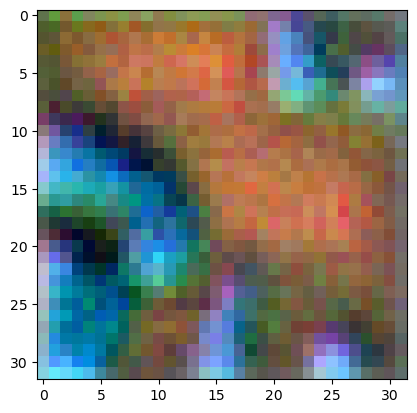

In [25]:
import matplotlib.pyplot as plt
plt.imshow(samples[3].detach().transpose(0,2) * 0.5 + 0.5)